# 3/25/21 - This notebook extracts information about total mass, stellar mass, and dark mass within the Einstein radius of completed models.

In [6]:
# libraries

from pyprojroot import here
print(f'You are here: {here()}')

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import scipy.stats as stats
from astropy.stats import sigma_clip as clip

from pyprojroot import here

%matplotlib inline

from astropy import constants as const
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value

c = const.c.to('km/s').value #c in km/s
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
cosmo = FlatLambdaCDM(h0, Om0=0.262)

# paths
autoz_path = f'{here()}/'
config_path = f'{here()}/config'
conf.instance.push(new_path=config_path)
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
latest_path = f'{csv_path}latest/'
visual_path = f'{autoz_path}visuals/'
png_path = f'{visual_path}png/'
pdf_path = f'{visual_path}pdf/'
knabel2020_file_path = '/data/sknabel/lens_methods/files/'
output_path = f'{autoz_path}output/'

In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_tes

You are here: /data/sknabel/autoz_lens_model


In [2]:
# define function

def extract_mass (instance):

    # lens and source galaxies
    lens_galaxy = instance.galaxies.lens
    source_galaxy = instance.galaxies.source
    # einstein radius and masses in angular units
    einstein_radius = lens_galaxy.einstein_radius_from_grid(grid=grid)
    einstein_mass_ang = lens_galaxy.einstein_mass_angular_from_grid(grid=grid)
    stellar_mass_ang = lens_galaxy.stellar_mass_angular_within_circle(radius=einstein_radius)
    dark_mass_ang = lens_galaxy.dark_mass_angular_within_circle(radius=einstein_radius)
    # critical surface density to convert masses to solar masses
    critical_surface_density = al.util.cosmology.critical_surface_density_between_redshifts_from(
        redshift_0=lens_galaxy.redshift,
        redshift_1=source_galaxy.redshift,
        cosmology=cosmo,
    )
    # masses in solar masses
    einstein_mass = einstein_mass_ang * critical_surface_density
    stellar_mass = stellar_mass_ang * critical_surface_density
    dark_mass = dark_mass_ang * critical_surface_density
    stellar_plus_dark_mass = stellar_mass + dark_mass # just to see if they're the same!
    # masses fractions
    stellar_fraction = stellar_mass / (stellar_plus_dark_mass)
    dark_fraction = dark_mass / (stellar_plus_dark_mass)
    
    # print results
    print(f'Einstein radius: {einstein_radius}')
    print(f'Einstein mass: {einstein_mass}')
    print(f'Stellar mass: {stellar_mass}')
    print(f'Dark mass: {dark_mass}')
    print(f'Stellar + Dark mass: {stellar_plus_dark_mass}')
    print(f'Stellar fraction: {stellar_fraction}')
    print(f'Dark fraction: {dark_fraction}')
    
    print()
    print("Can't build there!")

    return(einstein_radius.tolist(), 
           einstein_mass[0], 
           stellar_mass[0], 
           dark_mass[0], 
           stellar_plus_dark_mass[0], 
           stellar_fraction[0], 
           dark_fraction[0])

In [3]:
# set up empty dataframe
masses = pd.DataFrame(np.zeros(shape=(0,9)), columns = ['GAMA_ID', 
                                              'ID', 
                                              'einstein_radius',
                                             'einstein_mass',
                                             'stellar_mass',
                                             'dark_mass',
                                             'stellar_plus_dark_mass',
                                             'stellar_fraction',
                                             'dark_fraction'])

#masses.loc[-1] = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # adding a row
#masses.index = masses.index + 1  # shifting index
#masses = masses.sort_index()  # sorting by index
print(masses)

Empty DataFrame
Columns: [GAMA_ID, ID, einstein_radius, einstein_mass, stellar_mass, dark_mass, stellar_plus_dark_mass, stellar_fraction, dark_fraction]
Index: []


In [47]:
# extract from one output folder
# identify gama id and links id

print('Ah! Ya scared me!')
print('GAMA ID?')
gama_id = int(input())
print('LinKS ID?')
links_id = int(input())
#print('Phase folder identifier? (for agg filter)')
#filter_words = input()
print('You got it!')

model_path = f'{output_path}G{gama_id}_{links_id}/'

# specify grid
grid = al.Grid2D.uniform(shape_native=(101, 101), pixel_scales=0.2)

# load samples with aggregator
agg = af.Aggregator(directory=model_path)
agg_filter = agg.filter(agg.directory.contains('black_spot'))

# take median pdf instance
mpdf_instances = [samps.median_pdf_instance for samps in agg_filter.values("samples")]

for instance in mpdf_instances:
    print(instance)
    mass_output = list(extract_mass(instance))
    # insert gama and links ids at front
    mass_output.insert(0, links_id)
    mass_output.insert(0, gama_id)
    print(len(mass_output))
    # append masses dataframe
    masses.loc[-1] = mass_output  # adding a row
    masses.index = masses.index + 1  # shifting index
    masses = masses.sort_index()  # sorting by index
    print(masses)
    
    

Ah! Ya scared me!
GAMA ID?


 3891172


LinKS ID?


 3056


You got it!
Aggregator loading phases... could take some time.

 A total of 3 phases and results were found.
Filter found a total of 1 results
Einstein radius: 1.161351220000206
Einstein mass: [3.9105827e+11]
Stellar mass: [2.17422971e+11]
Dark mass: [1.89408701e+11]
Stellar + Dark mass: [4.06831672e+11]
Stellar fraction: [0.53442981]
Dark fraction: [0.46557019]

Can't build there!
9
     GAMA_ID      ID  einstein_radius  einstein_mass  stellar_mass  \
0  3891172.0  3056.0         1.161351   3.910583e+11  2.174230e+11   
1   250289.0  2730.0         1.540347   7.228025e+11  4.365238e+11   
2   250289.0  2730.0         1.203267   7.211000e+11  4.134884e+11   
3   250289.0  2730.0         0.698010   1.253757e+11  6.523529e+10   
4   250289.0  2730.0         1.161351   3.910583e+11  2.174230e+11   
5   250289.0  2730.0         0.964081   1.332862e+11  6.384931e+10   
6   250289.0  2730.0         1.522282   7.627499e+11  5.048455e+11   

      dark_mass  stellar_plus_dark_mass  stellar_fra

In [119]:
print(masses)

     GAMA_ID      ID  einstein_radius  einstein_mass  stellar_mass  \
1  3891172.0  3056.0         1.161351   3.910583e+11  2.174230e+11   
2   262874.0    26.0         0.698010   1.253757e+11  6.523529e+10   
3   138582.0  2828.0         1.203267   7.211000e+11  4.134884e+11   

      dark_mass  stellar_plus_dark_mass  stellar_fraction  dark_fraction  
1  1.894087e+11            4.068317e+11          0.534430       0.465570  
2  6.206128e+10            1.272966e+11          0.512467       0.487533  
3  3.184552e+11            7.319437e+11          0.564918       0.435082  


In [6]:
# load group catalog
groups = pd.read_csv(f'{csv_path}candidates_groups.csv')
groups.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA_x',
       'DEC_x', 'score', 'Unnamed: 0_y', 'z1', 'sigma1', 'template1', 'z2',
       'sigma2', 'template2', 'sigma3', 'sigma4', 'R', 'prob', 'error', 'type',
       'type_number', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'z', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass', 'P1',
       'P3', 'normalized_score', 'cnn_probability', 'm_half_re', 'sigma_star',
       'theta_e_pm', 'theta_e_sis', 'KIDS_ID', 'mag', 'mag_err', 'name',
       'num_0', 'probability', 'rms', 's*p/10', 'z_max', 'z_min', 'zphot',
       'RA_y', 'DEC_y', 'Z', 'Rpetro', 'DM_100_25_75', 'SURVEY_CODE', 'SigErr',
       'GroupID', 'RankIterCen', 'SepIterCen', 'CoSepIterCen', 'AngSepIterCen',
       'RankBCG', 'SepBCG', 'CoSepBCG', 'AngSepBCG', 'RankCen', 'SepCen',
       'CoSepCen', 'AngSepCen'],
      dtype='object')

In [121]:
# merge masses and groups
fdm_groups = pd.merge(masses, groups, how='left', on='GAMA_ID')
print(fdm_groups)

     GAMA_ID    ID_x  einstein_radius  einstein_mass  stellar_mass  \
0  3891172.0  3056.0         1.161351   3.910583e+11  2.174230e+11   
1   262874.0    26.0         0.698010   1.253757e+11  6.523529e+10   
2   138582.0  2828.0         1.203267   7.211000e+11  4.134884e+11   

      dark_mass  stellar_plus_dark_mass  stellar_fraction  dark_fraction  \
0  1.894087e+11            4.068317e+11          0.534430       0.465570   
1  6.206128e+10            1.272966e+11          0.512467       0.487533   
2  3.184552e+11            7.319437e+11          0.564918       0.435082   

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0_x    ID_y       RA_x    DEC_x  score  \
0          32            32            15  3056.0  139.22725 -1.54519   16.0   
1          34            34           329    26.0  221.61067  2.22389   12.0   
2          27            27           171  2828.0  183.14009 -1.82700   14.0   

   Unnamed: 0_y        z1    sigma1  template1        z2    sigma2  template2  \
0       6008

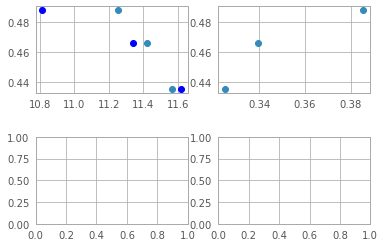

In [136]:
fig, axs = plt.subplots(2, 2)
axs[0,0].scatter(np.log10(fdm_groups.stellar_mass), fdm_groups.dark_fraction, color='blue')
axs[0,0].scatter(fdm_groups.lambdar_log_mstar, fdm_groups.dark_fraction)
axs[0,1].scatter(fdm_groups.zlens, fdm_groups.dark_fraction)


In [201]:
np.linspace(0,1,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

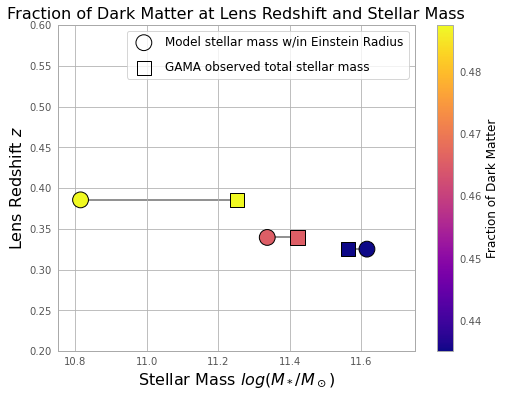

In [220]:
c = fdm_groups.dark_fraction
mass_err = fdm_groups.lambdar_log_mstar - np.log10(fdm_groups.stellar_mass)


figure, axs = plt.subplots(figsize=(8, 6))
axs.errorbar(np.log10(fdm_groups.stellar_mass), fdm_groups.zlens, 
                       xerr=mass_err,
                       marker='.', 
                         color='k',
                       linestyle='None',
                         ecolor='k',
                      xlolims = True,
                      label = None,
                      alpha = 0.5,
                        zorder=-1)
scatter = axs.scatter(np.log10(fdm_groups.stellar_mass), fdm_groups.zlens, 
                     marker='o',
                     edgecolor='black',
                     s=250,
                      c=c,
                     cmap='plasma',)
                     #label='Model stellar mass')
axs.scatter(fdm_groups.lambdar_log_mstar, fdm_groups.zlens, 
                     marker='s',
                     edgecolor='black',
                     s=200,
                      c=c,
                     cmap='plasma',)
                     #label='GAMA observed stellar mass')
axs.scatter(0, 0, 
                     marker='o',
                     edgecolor='black',
                     s=250,
                      c='None',
                     label='Model stellar mass w/in Einstein Radius')
axs.scatter(0, 0, 
                     marker='s',
                     edgecolor='black',
                     s=200,
                      c='None',
                     label='GAMA observed total stellar mass')
plt.colorbar(scatter, label='Fraction of Dark Matter',)
axs.set_title('Fraction of Dark Matter at Lens Redshift and Stellar Mass', fontsize=16)
axs.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=16)
axs.set_ylabel(r'Lens Redshift $z$', fontsize=16)
axs.set_xlim(10.75, 11.75)
axs.set_ylim(0.2, 0.6)
axs.legend(fontsize=12,
           labelspacing = 1.0)

#plt.savefig(f'{png_path}group_mass_to_stellar_mass.png')

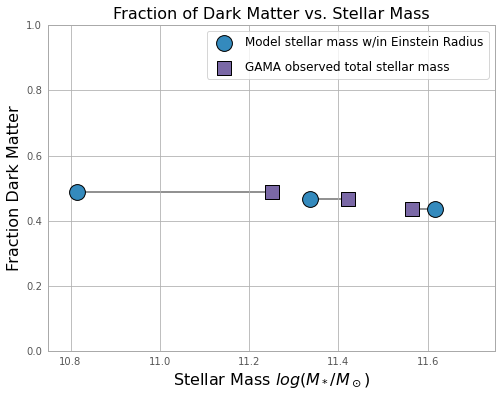

In [221]:
mass_err = fdm_groups.lambdar_log_mstar - np.log10(fdm_groups.stellar_mass)


figure, axs = plt.subplots(figsize=(8, 6))
axs.errorbar(np.log10(fdm_groups.stellar_mass), fdm_groups.dark_fraction, 
                       xerr=mass_err,
                       marker='.', 
                         color='k',
                       linestyle='None',
                         ecolor='k',
                      xlolims = True,
                      label = None,
                      alpha = 0.5,
                        zorder=-1)
scatter = axs.scatter(np.log10(fdm_groups.stellar_mass), fdm_groups.dark_fraction, 
                     marker='o',
                     edgecolor='black',
                     s=250,
                      #c=c,
                     #cmap='plasma',)
                     label='Model stellar mass w/in Einstein Radius')
axs.scatter(fdm_groups.lambdar_log_mstar, fdm_groups.dark_fraction, 
                     marker='s',
                     edgecolor='black',
                     s=200,
                      #c=c,
                     #cmap='plasma',)
                     label='GAMA observed total stellar mass')
#plt.colorbar(scatter, label='Fraction of Dark Matter',)
axs.set_title('Fraction of Dark Matter vs. Stellar Mass', fontsize=16)
axs.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=16)
axs.set_ylabel(r'Fraction Dark Matter', fontsize=16)
axs.set_xlim(10.75, 11.75)
axs.set_ylim(0.0, 1.0)
axs.legend(fontsize=12,
           labelspacing = 1.0)

# Iterate through all output folders marked with the black spot! (Billlly Bones, I know it's you!)

In [40]:
for i in range(len(agg_filter.phases)):
    gama_id, links_id = agg_filter.phases[i].file_path.split('/')[5][1:].split('_')
    print(gama_id, links_id)

544226 3212
3891172 3056
262874 26
138582 2828
3629152 1933
600305 245
585328 3234
250289 2730


In [5]:
# extract from all outputs marked with the black spot

print('Ah! Ya scared me!')
print('Phase folder identifier? (for agg filter)')
filter_words = input()
print('You got it!')

# set up empty dataframe
masses = pd.DataFrame(np.zeros(shape=(0,9)), columns = ['GAMA_ID', 
                                              'ID', 
                                              'einstein_radius',
                                             'einstein_mass',
                                             'stellar_mass',
                                             'dark_mass',
                                             'stellar_plus_dark_mass',
                                             'stellar_fraction',
                                             'dark_fraction'])

#masses.loc[-1] = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # adding a row
#masses.index = masses.index + 1  # shifting index
#masses = masses.sort_index()  # sorting by index
print(masses)

# specify grid
grid = al.Grid2D.uniform(shape_native=(101, 101), pixel_scales=0.2)

# load samples with aggregator
agg = af.Aggregator(directory=output_path)
agg_filter = agg.filter(agg.directory.contains(filter_words))

# take median pdf instance
mpdf_instances = [samps.median_pdf_instance for samps in agg_filter.values("samples")]

for i in range(len(mpdf_instances)):
    print("Order's received.")
    gama_id, links_id = agg_filter.phases[i].file_path.split('/')[5][1:].split('_')
    print(f'GAMA ID: {gama_id}, LinKS ID: {links_id}')
    instance = mpdf_instances[i]
    mass_output = list(extract_mass(instance))
    # insert gama and links ids at front
    mass_output.insert(0, links_id)
    mass_output.insert(0, gama_id)
    #print(len(mass_output))
    # append masses dataframe
    masses.loc[-1] = mass_output  # adding a row
    masses.index = masses.index + 1  # shifting index
    masses = masses.sort_index()  # sorting by index
    print("Job's finished!")

print(masses)

print("Job's finished!")



Ah! Ya scared me!
Phase folder identifier? (for agg filter)


 black_spot


You got it!
Empty DataFrame
Columns: [GAMA_ID, ID, einstein_radius, einstein_mass, stellar_mass, dark_mass, stellar_plus_dark_mass, stellar_fraction, dark_fraction]
Index: []
Aggregator loading phases... could take some time.

 A total of 188 phases and results were found.
Filter found a total of 7 results
Order's received.
GAMA ID: 544226, LinKS ID: 3212


INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Einstein radius: 0.9640808224533204
Einstein mass: [1.33286159e+11]
Stellar mass: [6.3849313e+10]
Dark mass: [6.96486635e+10]
Stellar + Dark mass: [1.33497977e+11]
Stellar fraction: [0.47827926]
Dark fraction: [0.52172074]

Can't build there!
Job's finished!
Order's received.
GAMA ID: 3891172, LinKS ID: 3056
Einstein radius: 1.161351220000206
Einstein mass: [3.9105827e+11]
Stellar mass: [2.17422971e+11]
Dark mass: [1.89408701e+11]
Stellar + Dark mass: [4.06831672e+11]
Stellar fraction: [0.53442981]
Dark fraction: [0.46557019]

Can't build there!
Job's finished!
Order's received.
GAMA ID: 262874, LinKS ID: 26
Einstein radius: 0.6980096554149677
Einstein mass: [1.25375672e+11]
Stellar mass: [6.5235287e+10]
Dark mass: [6.20612796e+10]
Stellar + Dark mass: [1.27296567e+11]
Stellar fraction: [0.51246698]
Dark fraction: [0.48753302]

Can't build there!
Job's finished!
Order's received.
GAMA ID: 138582, LinKS ID: 2828
Einstein radius: 1.203266891163765
Einstein mass: [7.21100023e+11]
Stellar 

In [7]:
# load group catalog
groups = pd.read_csv(f'{csv_path}candidates_groups.csv')
groups.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA_x',
       'DEC_x', 'score', 'Unnamed: 0_y', 'z1', 'sigma1', 'template1', 'z2',
       'sigma2', 'template2', 'sigma3', 'sigma4', 'R', 'prob', 'error', 'type',
       'type_number', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'z', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass', 'P1',
       'P3', 'normalized_score', 'cnn_probability', 'm_half_re', 'sigma_star',
       'theta_e_pm', 'theta_e_sis', 'KIDS_ID', 'mag', 'mag_err', 'name',
       'num_0', 'probability', 'rms', 's*p/10', 'z_max', 'z_min', 'zphot',
       'RA_y', 'DEC_y', 'Z', 'Rpetro', 'DM_100_25_75', 'SURVEY_CODE', 'SigErr',
       'GroupID', 'RankIterCen', 'SepIterCen', 'CoSepIterCen', 'AngSepIterCen',
       'RankBCG', 'SepBCG', 'CoSepBCG', 'AngSepBCG', 'RankCen', 'SepCen',
       'CoSepCen', 'AngSepCen'],
      dtype='object')

In [25]:
# merge masses and groups
masses.GAMA_ID = masses.GAMA_ID.astype(int)
masses.ID = masses.ID.astype(int)

masses.drop(1, inplace=True) # drop 3234, it's being redone anyway.

fdm_groups = pd.merge(masses, groups, how='left', on='GAMA_ID')
print(fdm_groups[ ['GAMA_ID', 'ID_x', 'dark_fraction', 'GroupID', 'RankIterCen'] ])


   GAMA_ID  ID_x  dark_fraction   GroupID  RankIterCen
0   250289  2730       0.338816  304825.0          1.0
1  3629152  1933       0.400617  106991.0          1.0
2   138582  2828       0.435082       0.0       -999.0
3   262874    26       0.487533       0.0       -999.0
4  3891172  3056       0.465570       0.0       -999.0
5   544226  3212       0.521721       0.0       -999.0


In [32]:
fdm_groups.to_csv(f'{csv_path}fdm_groups.csv')

In [27]:
grupos = fdm_groups[fdm_groups.GroupID != 0.0]
isos = fdm_groups[fdm_groups.GroupID == 0.0]

print(len(grupos), len(isos))

2 4


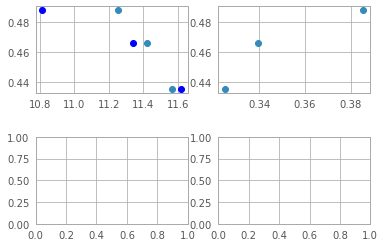

In [136]:
fig, axs = plt.subplots(2, 2)
axs[0,0].scatter(np.log10(grupos.stellar_mass), grupos.dark_fraction, color='k')
#axs[0,0].scatter(fdm_groups.lambdar_log_mstar, fdm_groups.dark_fraction)
axs[0,1].scatter(fdm_groups.zlens, fdm_groups.dark_fraction)


In [201]:
np.linspace(0,1,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

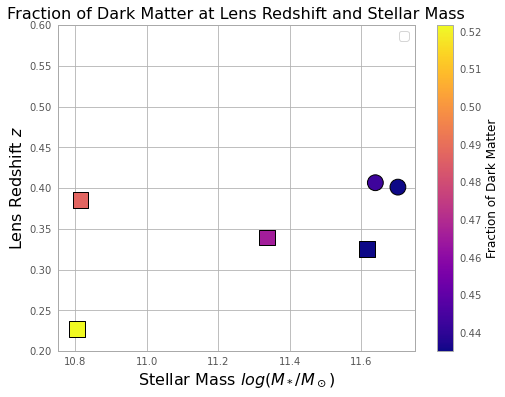

In [22]:
c = fdm_groups.dark_fraction
grupos_c = grupos.dark_fraction
grupos_mass_err = grupos.lambdar_log_mstar - np.log10(grupos.stellar_mass)
isos_c = isos.dark_fraction
isos_mass_err = isos.lambdar_log_mstar - np.log10(isos.stellar_mass)

figure, axs = plt.subplots(figsize=(8, 6))
#axs.errorbar(np.log10(grupos.stellar_mass), grupos.zlens, 
#                       xerr=grupos_mass_err,
#                       marker='.', 
#                         color='k',
#                       linestyle='None',
#                         ecolor='k',
#                      xlolims = True,
#                      label = None,
#                      alpha = 0.5,
#                        zorder=-1)
#axs.errorbar(np.log10(isos.stellar_mass), isos.zlens, 
#                       xerr=isos_mass_err,
#                       marker='.', 
#                         color='k',
#                       linestyle='None',
#                         ecolor='k',
#                      xlolims = True,
#                      label = None,
#                      alpha = 0.5,
#                        zorder=-1)
scatter_grupos = axs.scatter(np.log10(grupos.stellar_mass), grupos.zlens, 
                     marker='o',
                     edgecolor='black',
                     s=250,
                      c=grupos_c,
                     cmap='plasma',)
                     #label='Model stellar mass')
scatter_grupos = axs.scatter(np.log10(isos.stellar_mass), isos.zlens, 
                     marker='s',
                     edgecolor='black',
                     s=250,
                      c=isos_c,
                     cmap='plasma',)
                     #label='Model stellar mass')
#axs.scatter(fdm_groups.lambdar_log_mstar, fdm_groups.zlens, 
#                     marker='s',
#                     edgecolor='black',
#                     s=200,
#                      c=c,
#                     cmap='plasma',)
                     #label='GAMA observed stellar mass')
#axs.scatter(grupos.lambdar_log_mstar, grupos.zlens, 
 #                    marker='o',
 #                    edgecolor='black',
 #                    s=250,
 #                     c='None',
 #                    label='Model stellar mass w/in Einstein Radius')
#axs.scatter(isos.lambdar_log_mstar, isos.zlens, 
#                     marker='s',
#                     edgecolor='black',
#                     s=200,
#                      c='None',
#                     label='GAMA observed total stellar mass')
plt.colorbar(scatter_grupos, label='Fraction of Dark Matter',)
axs.set_title('Fraction of Dark Matter at Lens Redshift and Stellar Mass', fontsize=16)
axs.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=16)
axs.set_ylabel(r'Lens Redshift $z$', fontsize=16)
axs.set_xlim(10.75, 11.75)
axs.set_ylim(0.2, 0.6)
axs.legend(fontsize=12,
           labelspacing = 1.0)

#plt.savefig(f'{png_path}group_mass_to_stellar_mass.png')

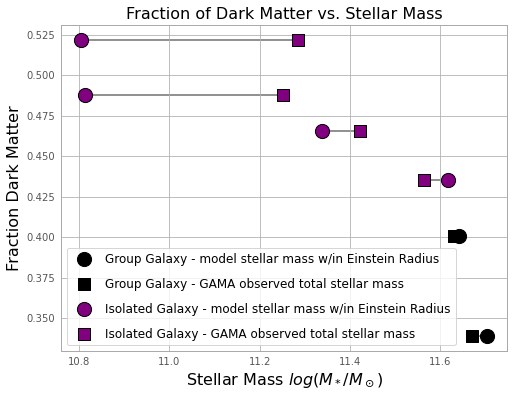

In [33]:
mass_err = fdm_groups.lambdar_log_mstar - np.log10(fdm_groups.stellar_mass)


figure, axs = plt.subplots(figsize=(8, 6))
axs.errorbar(np.log10(fdm_groups.stellar_mass), fdm_groups.dark_fraction, 
                       xerr=mass_err,
                       marker='.', 
                         color='k',
                       linestyle='None',
                         ecolor='k',
                      xlolims = True,
                      label = None,
                      alpha = 0.5,
                        zorder=-1)
scatter = axs.scatter(np.log10(grupos.stellar_mass), grupos.dark_fraction, 
                     marker='o',
                     edgecolor='black',
                     s=200,
                      c='black',
                     #cmap='plasma',)
                     label='Group Galaxy - model stellar mass w/in Einstein Radius')
axs.scatter(grupos.lambdar_log_mstar, grupos.dark_fraction, 
                     marker='s',
                     edgecolor='black',
                     s=150,
                      c='black',
                     #cmap='plasma',)
                     label='Group Galaxy - GAMA observed total stellar mass')
scatter = axs.scatter(np.log10(isos.stellar_mass), isos.dark_fraction, 
                     marker='o',
                     edgecolor='black',
                     s=200,
                      c='purple',
                     #cmap='plasma',)
                     label='Isolated Galaxy - model stellar mass w/in Einstein Radius')
axs.scatter(isos.lambdar_log_mstar, isos.dark_fraction, 
                     marker='s',
                     edgecolor='black',
                     s=150,
                      c='purple',
                     #cmap='plasma',)
                     label='Isolated Galaxy - GAMA observed total stellar mass')
#plt.colorbar(scatter, label='Fraction of Dark Matter',)
axs.set_title('Fraction of Dark Matter vs. Stellar Mass', fontsize=16)
axs.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=16)
axs.set_ylabel(r'Fraction Dark Matter', fontsize=16)
#axs.set_xlim(10.75, 11.75)
#axs.set_ylim(0.0, 1.0)
axs.legend(fontsize=12,
           labelspacing = 1.0)
#plt.savefig(f'{png_path}fdm_vs_stellar_mass_032621.png')

# Let's try to get error bars in here.

In [110]:
# extract from all outputs marked with the black spot

print('Ah! Ya scared me!')
print('Phase folder identifier? (for agg filter)')
filter_words = input()
print('You got it!')

# set up empty dataframe
masses = pd.DataFrame(np.zeros(shape=(0,23)), columns = ['GAMA_ID', 
                                                          'ID', 
                                                          'einstein_radius',
                                                         'einstein_mass',
                                                         'stellar_mass',
                                                         'dark_mass',
                                                         'stellar_plus_dark_mass',
                                                         'stellar_fraction',
                                                         'dark_fraction',
                                                         'einstein_radius_ue3',
                                                         'einstein_mass_ue3',
                                                         'stellar_mass_ue3',
                                                         'dark_mass_ue3',
                                                         'stellar_plus_dark_mass_ue3',
                                                         'stellar_fraction_ue3',
                                                         'dark_fraction_ue3',
                                                        'einstein_radius_le3',
                                                         'einstein_mass_le3',
                                                         'stellar_mass_le3',
                                                         'dark_mass_le3',
                                                         'stellar_plus_dark_mass_le3',
                                                         'stellar_fraction_le3',
                                                         'dark_fraction_le3'
                                                        ])

#masses.loc[-1] = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # adding a row
#masses.index = masses.index + 1  # shifting index
#masses = masses.sort_index()  # sorting by index
print(masses)

# specify grid
grid = al.Grid2D.uniform(shape_native=(101, 101), pixel_scales=0.2)

# load samples with aggregator
agg = af.Aggregator(directory=output_path)
agg_filter = agg.filter(agg.directory.contains(filter_words))

# take median pdf instance
mpdf_instances = [samps.median_pdf_instance for samps in agg_filter.values("samples")]
ue3_instances = [samps.instance_at_upper_sigma(sigma=3.0)for samps in agg_filter.values("samples")]
le3_instances = [samps.instance_at_lower_sigma(sigma=3.0)for samps in agg_filter.values("samples")]

for i in range(len(mpdf_instances)):
    print("Order's received.")
    gama_id, links_id = agg_filter.phases[i].file_path.split('/')[5][1:].split('_')
    print(f'GAMA ID: {gama_id}, LinKS ID: {links_id}')
    # median pdf instance
    print('Median pdf instance')
    mpdf_instance = mpdf_instances[i]
    mpdf_mass_output = list(extract_mass(mpdf_instance))
    # upper 3-sigma instance
    print('Upper 3-sigma instance')
    ue3_instance = ue3_instances[i]
    ue3_mass_output = list(extract_mass(ue3_instance))
    # lower 3-sigma instance
    print('Lower 3-sigma instance')
    le3_instance = le3_instances[i]
    le3_mass_output = list(extract_mass(le3_instance))
    # insert gama and links ids at front
    mass_output = [gama_id, links_id] + mpdf_mass_output + ue3_mass_output + le3_mass_output
    print(len(mass_output))
    # append masses dataframe
    masses.loc[-1] = mass_output  # adding a row
    masses.index = masses.index + 1  # shifting index
    masses = masses.sort_index()  # sorting by index
    print("Job's finished!")

print(masses)

print("Job's finished!")


Ah! Ya scared me!
Phase folder identifier? (for agg filter)


 black_spot


You got it!
Empty DataFrame
Columns: [GAMA_ID, ID, einstein_radius, einstein_mass, stellar_mass, dark_mass, stellar_plus_dark_mass, stellar_fraction, dark_fraction, einstein_radius_ue3, einstein_mass_ue3, stellar_mass_ue3, dark_mass_ue3, stellar_plus_dark_mass_ue3, stellar_fraction_ue3, dark_fraction_ue3, einstein_radius_le3, einstein_mass_le3, stellar_mass_le3, dark_mass_le3, stellar_plus_dark_mass_le3, stellar_fraction_le3, dark_fraction_le3]
Index: []
Aggregator loading phases... could take some time.

 A total of 188 phases and results were found.
Filter found a total of 7 results
Order's received.
GAMA ID: 544226, LinKS ID: 3212
Median pdf instance
Einstein radius: 0.9640808224533204
Einstein mass: [1.33286159e+11]
Stellar mass: [6.3849313e+10]
Dark mass: [6.96486635e+10]
Stellar + Dark mass: [1.33497977e+11]
Stellar fraction: [0.47827926]
Dark fraction: [0.52172074]

Can't build there!
Upper 3-sigma instance
Einstein radius: 1.7758005064965685
Einstein mass: [4.52216617e+11]
Stel

In [111]:
# load group catalog
groups = pd.read_csv(f'{csv_path}candidates_groups.csv')
groups.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA_x',
       'DEC_x', 'score', 'Unnamed: 0_y', 'z1', 'sigma1', 'template1', 'z2',
       'sigma2', 'template2', 'sigma3', 'sigma4', 'R', 'prob', 'error', 'type',
       'type_number', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'z', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass', 'P1',
       'P3', 'normalized_score', 'cnn_probability', 'm_half_re', 'sigma_star',
       'theta_e_pm', 'theta_e_sis', 'KIDS_ID', 'mag', 'mag_err', 'name',
       'num_0', 'probability', 'rms', 's*p/10', 'z_max', 'z_min', 'zphot',
       'RA_y', 'DEC_y', 'Z', 'Rpetro', 'DM_100_25_75', 'SURVEY_CODE', 'SigErr',
       'GroupID', 'RankIterCen', 'SepIterCen', 'CoSepIterCen', 'AngSepIterCen',
       'RankBCG', 'SepBCG', 'CoSepBCG', 'AngSepBCG', 'RankCen', 'SepCen',
       'CoSepCen', 'AngSepCen'],
      dtype='object')

In [113]:
# merge masses and groups
masses.GAMA_ID = masses.GAMA_ID.astype(int)
masses.ID = masses.ID.astype(int)

masses.drop(1, inplace=True) # drop 3234, it's being redone anyway.

fdm_groups = pd.merge(masses, groups, how='left', on='GAMA_ID')
print(fdm_groups[ ['GAMA_ID', 'ID_x', 'stellar_mass', 'stellar_mass_ue3', 'stellar_mass_le3', 'dark_fraction', 'dark_fraction_ue3', 'dark_fraction_le3', 'GroupID',] ])


   GAMA_ID  ID_x  stellar_mass  stellar_mass_ue3  stellar_mass_le3  \
0   250289  2730  5.048455e+11      7.479408e+11      3.139831e+11   
1  3629152  1933  4.365238e+11      2.357477e+12      2.340854e+10   
2   138582  2828  4.134884e+11      1.929507e+12      5.396027e+10   
3   262874    26  6.523529e+10      1.445065e+11      1.727966e+10   
4  3891172  3056  2.174230e+11      4.495800e+11      1.015656e+11   
5   544226  3212  6.384931e+10      2.001218e+11      1.187248e+10   

   dark_fraction  dark_fraction_ue3  dark_fraction_le3   GroupID  
0       0.338816           0.401519           0.276734  304825.0  
1       0.400617           0.486639           0.229455  106991.0  
2       0.435082           0.466698           0.407184       0.0  
3       0.487533           0.485486           0.533015       0.0  
4       0.465570           0.501455           0.422361       0.0  
5       0.521721           0.558128           0.423708       0.0  


In [114]:
grupos = fdm_groups[fdm_groups.GroupID != 0.0]
isos = fdm_groups[fdm_groups.GroupID == 0.0]

print(len(grupos), len(isos))

2 4


In [115]:
fdm_groups.columns

Index(['GAMA_ID', 'ID_x', 'einstein_radius', 'einstein_mass', 'stellar_mass',
       'dark_mass', 'stellar_plus_dark_mass', 'stellar_fraction',
       'dark_fraction', 'einstein_radius_ue3', 'einstein_mass_ue3',
       'stellar_mass_ue3', 'dark_mass_ue3', 'stellar_plus_dark_mass_ue3',
       'stellar_fraction_ue3', 'dark_fraction_ue3', 'einstein_radius_le3',
       'einstein_mass_le3', 'stellar_mass_le3', 'dark_mass_le3',
       'stellar_plus_dark_mass_le3', 'stellar_fraction_le3',
       'dark_fraction_le3', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0_x',
       'ID_y', 'RA_x', 'DEC_x', 'score', 'Unnamed: 0_y', 'z1', 'sigma1',
       'template1', 'z2', 'sigma2', 'template2', 'sigma3', 'sigma4', 'R',
       'prob', 'error', 'type', 'type_number', 'lambdar_log_mstar',
       'lambdar_mstar', 'lambdar_log_mstar_error', 'z', 'zlens', 'zsource',
       'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass', 'P1', 'P3', 'normalized_score',
       'cnn_probability', 

In [25]:
for i in range(len(grupos)):
    print(grupos.iloc[i].GAMA_ID)

250289
3629152


In [102]:
print(fdm_groups.dark_fraction_ue3)
print(fdm_groups.dark_fraction)

0    0.401519
1    0.486639
2    0.466698
3    0.485486
4    0.501455
5    0.558128
Name: dark_fraction_ue3, dtype: float64
0    0.338816
1    0.400617
2    0.435082
3    0.487533
4    0.465570
5    0.521721
Name: dark_fraction, dtype: float64


In [116]:
# link the different stellar mass measurements
mass_diff = fdm_groups.lambdar_log_mstar - np.log10(fdm_groups.stellar_mass)

# set up upper and lower errors
model_mass_uerr = np.array(np.log10(fdm_groups.stellar_mass_ue3) - np.log10(fdm_groups.stellar_mass))
model_mass_lerr = np.array(np.log10(fdm_groups.stellar_mass) - np.log10(fdm_groups.stellar_mass_le3))
gama_mass_err = np.array(fdm_groups.lambdar_log_mstar_error)
fdm_uerr = np.array(fdm_groups.dark_fraction_ue3 - fdm_groups.dark_fraction)
fdm_lerr = np.array(fdm_groups.dark_fraction - fdm_groups.dark_fraction_ue3)

print(model_mass_lerr, gama_mass_err, fdm_uerr, fdm_lerr)

[0.20625217 1.27063365 0.88438922 0.57694742 0.33055877 0.73061463] [0.10072876 0.11205658 0.12026352 0.12878208 0.11927549 0.11088524] [ 0.06270261  0.0860219   0.03161631 -0.00204751  0.03588504  0.0364073 ] [-0.06270261 -0.0860219  -0.03161631  0.00204751 -0.03588504 -0.0364073 ]


In [5]:
# plot

#####
# start figure
fig, axs = plt.subplots(figsize=(8, 6))

# mass diff line
#axs.errorbar(np.log10(fdm_groups.stellar_mass), fdm_groups.dark_fraction, 
#                       xerr=mass_diff,
#                       marker='.', 
#                         color='k',
#                       linestyle='None',
#                         ecolor='k',
#                         elinewidth=1,
#                      xlolims = True,
#                      label = None,
#                      alpha = 0.5,
#                        zorder=-1)

# plot errors
axs.errorbar(np.log10(fdm_groups.stellar_mass), fdm_groups.dark_fraction, 
             marker='.',
             #markeredgecolor='black',
             #markersize=200,
              #mfc='black',
             #ecolor='k',
             linestyle='None',
             #yerr=(fdm_lerr, fdm_uerr),
             xerr=(model_mass_lerr, model_mass_uerr),
             #cmap='plasma',)
             label='Model Stellar Mass Error',
             elinewidth=2.0,
             zorder=-1,
             capsize=4.0
                )
#axs.errorbar(fdm_groups.lambdar_log_mstar, fdm_groups.dark_fraction, 
#             marker='.',
             #markeredgecolor='black',
             #markersize=150,
             # mfc='black',
             #ecolor='b',
#             linestyle='None',
#             xerr=gama_mass_err,
             #yerr=(fdm_lerr, fdm_uerr),
             #cmap='plasma',)
#             label='LAMBDAR Stellar Mass Error',
#             zorder=-1,
#             capsize=4.0
#                )

axs.scatter(np.log10(grupos.stellar_mass), grupos.dark_fraction, 
                     marker='o',
                     edgecolor='black',
                     s=200,
                      c='black',
                     #cmap='plasma',)
                     label='Group Galaxy - model stellar mass w/in Einstein Radius')
#axs.scatter(grupos.lambdar_log_mstar, grupos.dark_fraction, 
#                     marker='s',
#                     edgecolor='black',
#                     s=150,
#                      c='black',
                     #cmap='plasma',)
#                     label='Group Galaxy - GAMA observed total stellar mass')
axs.scatter(np.log10(isos.stellar_mass), isos.dark_fraction, 
                     marker='o',
                     edgecolor='black',
                     s=200,
                      c='purple',
                     #cmap='plasma',)
                     label='Isolated Galaxy - model stellar mass w/in Einstein Radius')
axs.scatter(isos.lambdar_log_mstar, isos.dark_fraction, 
                     marker='s',
                     edgecolor='black',
                     s=150,
                      c='purple',
                     #cmap='plasma',)
                     label='Isolated Galaxy - GAMA observed total stellar mass')

#plt.colorbar(scatter, label='Fraction of Dark Matter',)
axs.set_title('Fraction of Dark Matter vs. Stellar Mass', fontsize=16)
axs.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=16)
axs.set_ylabel(r'Fraction Dark Matter', fontsize=16)
#axs.set_xlim(10.75, 11.75)
#axs.set_ylim(0.0, 1.0)
#axs.legend(fontsize=12,
#           labelspacing = 1.0)
#plt.savefig(f'{png_path}fdm_vs_stellar_mass_032621.png')

NameError: name 'plt' is not defined

In [124]:
# example data
x = np.array([1,2])#np.arange(0.1, 4, 0.5)
y = np.array([1,2])#np.exp(-x)

# example error bar values that vary with x-position
error = 0.1 + 0.2 * x

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(x, y, yerr=error, fmt='-o')
ax0.set_title('variable, symmetric error')

# error bar values w/ different -/+ errors that
# also vary with the x-position
lower_error = 0.4 * error
upper_error = error
print(upper_error)

asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x, y, xerr=asymmetric_error, yerr=asymmetric_error, fmt='o')
ax1.set_title('variable, asymmetric error')
ax1.set_yscale('log')
plt.show()

TypeError: cannot unpack non-iterable AxesSubplot object

<ErrorbarContainer object of 3 artists>

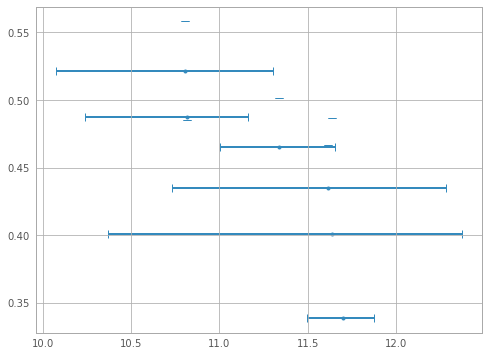

In [100]:

# plot errors
plt, axs = plt.subplots(figsize=(8,6))
axs.errorbar(np.log10(fdm_groups.stellar_mass), fdm_groups.dark_fraction, 
             marker='.',
             #markeredgecolor='black',
             #markersize=200,
              #mfc='black',
             #ecolor='k',
             linestyle='None',
             yerr=(fdm_lerr, fdm_uerr),
             xerr=(model_mass_lerr, model_mass_uerr),
             #cmap='plasma',)
             label='Model Stellar Mass Error',
             elinewidth=2.0,
             zorder=-1,
             capsize=4.0
                )

In [ ]:
data = fits.open(f'{fits_path}LambdarInputCatUVOptNIR.fits')[1].data
print(data.columns.names)
data_byte_swap=data.byteswap().newbyteorder()

apertures = pd.DataFrame(data_byte_swap[:], columns = data.columns.names)
apertures.rename(columns={'CATAID':'GAMA_ID'}, inplace=True)
print(apertures.columns)

candidates = pd.read_csv(f'{latest_path}all_samples_latest.csv')

candidates_apertures = pd.merge(candidates, apertures, how='left', on='GAMA_ID')
print(candidates_apertures[['GAMA_ID','ID','RADMAJ','RADMIN']])

In [146]:
print(candidates_apertures.columns)
print(candidates_apertures[['GAMA_ID','ID','RADMAJ','RADMIN']])

Index(['Unnamed: 0', 'DEC_x', 'GAMA_ID', 'ID', 'KIDS_ID', 'P1', 'P3', 'R',
       'RA_x', 'Unnamed: 0_x', 'Unnamed: 0_y', 'cnn_probability',
       'corrected_stellar_mass', 'dlens', 'dsource', 'error',
       'lambdar_log_mstar', 'lambdar_log_mstar_error', 'lambdar_mstar', 'mag',
       'mag_err', 'name', 'normalized_score', 'num_0', 'prob', 'probability',
       'rms', 's*p/10', 'score', 'sigma1', 'sigma2', 'sigma3', 'sigma4',
       'sigma_lens', 'sigma_source', 'template1', 'template2', 'type',
       'type_number', 'z', 'z1', 'z2', 'z_max', 'z_min', 'zlens', 'zphot',
       'zsource', 'LAMID', 'RA_y', 'DEC_y', 'ROTN2E', 'RADMAJ', 'RADMIN',
       'AP_ORIGIN', 'CONTAM'],
      dtype='object')
      GAMA_ID      ID     RADMAJ     RADMIN
0    600305.0   245.0  10.626929  10.433950
1    419067.0  1179.0   8.078142   7.588664
2    387244.0  1819.0   6.045559   5.775358
3   3611088.0  1743.0   6.914312   6.888985
4    373093.0  2897.0   7.088555   5.671521
5    585328.0  3234.0   9.6058